# Movie Recommendation by Surprise

## Matrix Factorization method for Collaborative Filtering
Matrix Factorization is a popular technique used in collaborative filtering to predict user-item ratings based on the previous ratings given by users. Collaborative Filtering is a type of recommendation system that relies on the past behavior of similar users/items to make recommendations.

Matrix Factorization is based on the idea of decomposing the user-item rating matrix into two lower-dimensional matrices: one representing users and the other representing items. The lower-dimensional representation captures the latent factors or features that influence a user's preference for an item. The factors may include, for example, the genre of the movie, the director, the actors, or the user's age, gender, etc.


In [1]:
import sys
import random
from surprise import Dataset, Reader
from surprise import SVD
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise.dataset import DatasetAutoFolds
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import operator
import requests
from zipfile import ZipFile

In [2]:
df = pd.read_csv('/kaggle/input/movie-recommendation-system/ratings.csv', 
                          error_bad_lines=False, 
                          warn_bad_lines=False,
                          skiprows=lambda i: i>0 and random.random() > 0.002)
print(len(df))

/tmp/ipykernel_20/1924962599.py:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv('/kaggle/input/movie-recommendation-system/ratings.csv',
/tmp/ipykernel_20/1924962599.py:1: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv('/kaggle/input/movie-recommendation-system/ratings.csv',


49812


In [3]:
df=df[0:30000]

In [4]:
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(df[['userId','movieId','rating']], reader)
print(type(data))

<class 'surprise.dataset.DatasetAutoFolds'>


Sample datasets provided by the Surprise package are as follows.

* ml-100k: MovieLens dataset containing 100,000 ratings.
* ml-1m: MovieLens dataset containing 1,000,000 ratings.
* jester: Jester dataset. Anything that includes online joke ratings.
* bookcrossing: Book-Crossing dataset. Including book ratings.
* movielens: MovieLens dataset. There are four versions, 100k, 1M, 10M and 20M, each containing a corresponding number of ratings.

In [5]:
# Split the data into training and testing sets
trainset, testset = train_test_split(data, test_size=0.30)
print(type(trainset))

<class 'surprise.trainset.Trainset'>


In [6]:
import itertools

for uid, iid, rating in itertools.islice(trainset.all_ratings(), 5):
    print(f"User {uid} rated item {iid} with a rating of {rating}")

print()
for uid, iid, rating in testset[:5]:
    print(f"User {uid} rated item {iid} with a rating of {rating}")
    
print()    
print(trainset.n_ratings,len(testset))

User 0 rated item 0 with a rating of 4.0
User 1 rated item 1 with a rating of 2.0
User 1 rated item 1602 with a rating of 3.5
User 2 rated item 2 with a rating of 5.0
User 2 rated item 2136 with a rating of 4.0

User 66041 rated item 1374 with a rating of 4.0
User 74674 rated item 2714 with a rating of 3.5
User 1748 rated item 1327 with a rating of 1.0
User 25151 rated item 6934 with a rating of 3.5
User 31716 rated item 3255 with a rating of 4.0

21000 9000


## SVD
SVD is used as a collaborative filtering technique. It uses a matrix structure where each row represents a user, and each column represents an item. The elements of this matrix are the ratings that are given to items by users.

In [7]:
# Use the KNNBasic algorithm to train the model 
algo = SVD()
algo.fit(trainset)

In [8]:
# Test the model on the testing set
predictions = algo.test(testset)

In [9]:
for uid, iid, rating in testset[:5]:
    print(f"User {uid} rated item {iid} with a rating of {rating}")

User 66041 rated item 1374 with a rating of 4.0
User 74674 rated item 2714 with a rating of 3.5
User 1748 rated item 1327 with a rating of 1.0
User 25151 rated item 6934 with a rating of 3.5
User 31716 rated item 3255 with a rating of 4.0


The 'predictions' is a list of tuples of the form (user, item, actual_rating, predicted_rating, details). The predicted_rating is est value.

In [10]:
for prediction in predictions[0:5]:
    print(prediction)

user: 66041      item: 1374       r_ui = 4.00   est = 3.72   {'was_impossible': False}
user: 74674      item: 2714       r_ui = 3.50   est = 3.64   {'was_impossible': False}
user: 1748       item: 1327       r_ui = 1.00   est = 3.29   {'was_impossible': False}
user: 25151      item: 6934       r_ui = 3.50   est = 3.27   {'was_impossible': False}
user: 31716      item: 3255       r_ui = 4.00   est = 3.32   {'was_impossible': False}


In [11]:
# Print the performance metrics
accuracy.rmse(predictions)

RMSE: 1.0148


1.014769893458719

In [12]:
true_ratings = [pred.r_ui for pred in predictions]
est_ratings = [pred.est for pred in predictions]
uids = [pred.uid for pred in predictions]

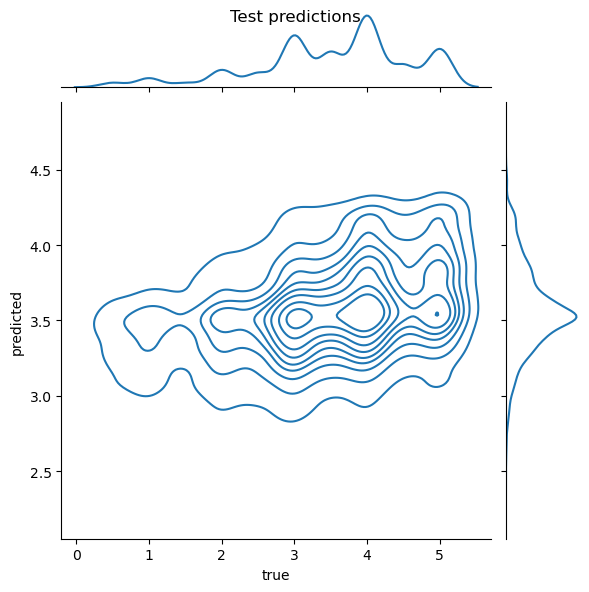

In [13]:
data=pd.DataFrame(columns=["true","predicted"])
data["true"]=true_ratings
data["predicted"]=est_ratings
g = sns.jointplot(data=data,x="true", y="predicted", kind="kde",)
g.fig.suptitle('Test predictions',fontsize=12)
plt.show()

# Recommend unseen movies for test set users

In [14]:
movies=pd.read_csv('/kaggle/input/movie-recommendation-system/movies.csv')
mapping = movies.set_index("movieId")["title"].to_dict()

In [15]:
users=list(set(uids))

In [16]:
# items which the user not yet evaluate
items = trainset.build_anti_testset()
for user in users[0:30]:
    user_items = list(filter(lambda x: x[0] == user, items))
    #print(user,len(user_items))
    # generate recommendation
    recommendations = algo.test(user_items)
    if len(recommendations)>0:
        recommendations.sort(key=operator.itemgetter(3), reverse=True)
        print(f"For User {user}, Recommendations:")
        for r in recommendations[0:5]:
            print(f"  {mapping[r[1]]} : Estimated rating {round(r[3],4)}")

For User 3, Recommendations:
  Casablanca (1942) : Estimated rating 4.4137
  Braveheart (1995) : Estimated rating 4.3844
  Godfather: Part II, The (1974) : Estimated rating 4.3783
  Good Will Hunting (1997) : Estimated rating 4.3677
  Matrix, The (1999) : Estimated rating 4.3554
For User 32778, Recommendations:
  12 Angry Men (1957) : Estimated rating 4.3439
  Monty Python and the Holy Grail (1975) : Estimated rating 4.34
  O Brother, Where Art Thou? (2000) : Estimated rating 4.3089
  Shawshank Redemption, The (1994) : Estimated rating 4.2655
  Pulp Fiction (1994) : Estimated rating 4.2347
For User 65549, Recommendations:
  American Beauty (1999) : Estimated rating 4.5466
  Departed, The (2006) : Estimated rating 4.5309
  Shawshank Redemption, The (1994) : Estimated rating 4.5147
  Pulp Fiction (1994) : Estimated rating 4.5086
  Godfather: Part II, The (1974) : Estimated rating 4.4709
For User 32785, Recommendations:
  Shawshank Redemption, The (1994) : Estimated rating 4.5513
  Fight 